# 인공지능과 가위 바위 보 하기



가위 바위 보 이미지를 학습하여 인식하는 모델을 만들어 보자.

### 필요한 모듈 import

In [1]:
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import glob
import os

## 1. 데이터 만들기

학습 시킬 이미지를 준비한다.  
https://teachablemachine.withgoogle.com/ 에서 가위, 바위, 보를 각 100장씩 찍었다.  
데이터 라벨을 분류하기 편하게 각 이미지를 scissor, rock, paper 폴더에 저장했다.

테스트 데이터는 나중에 다른 분들이 올린 데이터를 사용할 예정이다.

폴더에 이미지가 있는지 확인해보자.

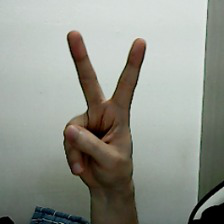

In [2]:
Image.open(os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/0.jpg")

## 2. 이미지 Resize 하기

현재 이미지 크기는 224x224로 28x28로 크기를 변경한다.  
다음은 크기를 변경해주는 함수이다.

In [3]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(f"{len(images)} 개의 이미지 크기변경")

In [4]:
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper")

100 개의 이미지 크기변경
100 개의 이미지 크기변경
100 개의 이미지 크기변경


300개의 이미지의 크기를 변경하였다.  
변경된 이미지를 확인해보자.

In [5]:
Image.open(os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/0.jpg")

## 3. 데이터 불러오기

이제 각 폴더에 저장되어 있는 이미지를 불러서 학습 데이터를 만든다.  
여기서 중요한건 각 파일마다 라벨링을 해준다.

    가위 : 0,  바위 :1,  보 : 2
    
다음은 그 역할을 해주는 함수이다.

In [6]:
def load_data(img_path, number_of_data=300): # 총 이미지가 300을 넘을 경우 파라미터 변경
    # 가위 : 0, 바위 : 1, 보 : 2
    #이미지 데이터와 라벨 데이터를 담을 행렬영역을 생성
    x_data=np.zeros([number_of_data,28,28,3],dtype=np.int32)
    y_data=np.zeros(number_of_data,dtype=np.int32)   # 라벨 데이터

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        x_data[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        y_data[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        x_data[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        y_data[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        x_data[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        y_data[idx]=2   # 보 : 2
        idx=idx+1
    
    print(f"로드된 데이터의 이미지 개수는 {idx} 입니다.")
    return x_data, y_data

In [7]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)  # 데이터 로드

로드된 데이터의 이미지 개수는 300 입니다.


300개의 이미지로 학습 데이터와 라벨을 만들었다.  
확인을 해보자.

라벨: 2


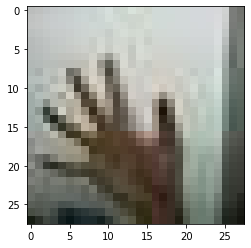

In [8]:
plt.imshow(x_train[210])
print(f"라벨: {y_train[210]}")

데이터는 잘 불려졌으니 빠른 학습을 위해 정규화를 시킨다.

추가로 여기서 데이터를 섞어준다.  
현재 데이터는 가위100, 바위100, 보100순서로 정렬되어 있다.

문제는 검증용으로 사용하는 tensorflow의 fir(validation_split=0.2)이 
데이터를 끝에서 부터 비율만큼 잘라서 쓴다.

그래서 현재 데이터를 검증용으로 사용하면 보만 잘려나가게 되고,  
0.4정도 비율이면 보 자체가 사라져서 학습이 잘되지 않는다.  
그러니 학습을 하기 전에 데이터를 섞어준다.

그 외에도 만약 mini batch등으로 학습할 경우 이런 정렬된 데이터는 좋지않다.

In [9]:
order = list(range(len(y_train)))     # x와 y의 인덱스를 동일하게 섞기 위한 리스트
random.shuffle(order)

x_train = x_train[order]/255.0   # 입력은 0~1 사이의 값으로 정규화
y_train = y_train[order]         # 인덱스를 섞은 order로 주어 똑같이 섞이게 만든다.

## 4. 딥러닝 네트워크 설계하기

준비된 데이터를 학습시킬 모델을 구성해보자.  
다음은 학습에 사용될 하이퍼 파라미터들과 학습 모델 구성이다.

In [10]:
# 학습에 사용되는 하이퍼 파라미터들
channels_1 = 64
channels_2 = 128
channels_3 = 128
dense_output = 128
learning_rate = 0.001
train_epochs = 40
validation_split = 0.1

model=keras.models.Sequential()

model.add(keras.layers.Conv2D(channels_1, (3,3), activation='relu', input_shape=(28,28,3), padding='SAME'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channels_2, (3,3), activation='relu', padding='SAME'))
model.add(keras.layers.Conv2D(channels_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_output, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

## 5. 딥러닝 네트워크 학습시키기

학습과정 중의 학습율 변화를 확인하기 위해 validation_split을 하이퍼 파라미터로 주었다.

그리고 학습한 결과를 받아서 그래프로 나타내었다.

Epoch 1/40
9/9 [==============================] - 11s 687ms/step - loss: 1.6943 - accuracy: 0.2500 - val_loss: 1.2073 - val_accuracy: 0.3333
Epoch 2/40
9/9 [==============================] - 0s 14ms/step - loss: 1.1455 - accuracy: 0.3452 - val_loss: 1.0920 - val_accuracy: 0.5000
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 1.0744 - accuracy: 0.4983 - val_loss: 0.9852 - val_accuracy: 0.7333
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.9628 - accuracy: 0.6494 - val_loss: 0.9015 - val_accuracy: 0.5333
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.7158 - accuracy: 0.7413 - val_loss: 0.6542 - val_accuracy: 0.7333
Epoch 6/40
9/9 [==============================] - 0s 13ms/step - loss: 0.4456 - accuracy: 0.8377 - val_loss: 0.6173 - val_accuracy: 0.7667
Epoch 7/40
9/9 [==============================] - 0s 14ms/step - loss: 0.4413 - accuracy: 0.8247 - val_loss: 0.5114 - val_accuracy: 0.8000
Epoch 8/40
9/9 [=========

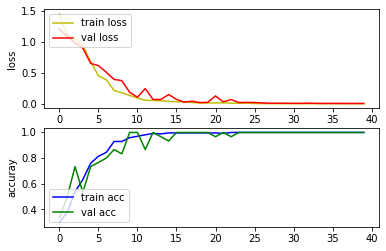

In [11]:
hist = model.fit(x_train, y_train, epochs=train_epochs, validation_split=validation_split)
    
# 기록들을 그래프로 나타낸다.
fig = plt.figure()
loss_ax = fig.add_subplot(2, 1, 1)
acc_ax = fig.add_subplot(2, 1, 2)

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

같은 환경에서 찍은 사진을 검증데이터로 썼기 때문에 검증데이터까지 1.0이 나왔다.

## 6. 테스트 데이터 불러오기

이제 다른 분들께서 올려주신 데이터를 이용해서 실제 테스트를 해보자.

학습 데이터와 같은 방법으로 다운받은 이미지의 크기를 변경하고,  
변경된 이미지를 위에서 만든 함수로 불러오자.

테스트 데이터는 따로 test폴더에서 나누어 저장하였다.

In [12]:
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper")

100 개의 이미지 크기변경
100 개의 이미지 크기변경
100 개의 이미지 크기변경


In [13]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path)  # 데이터 로드

로드된 데이터의 이미지 개수는 300 입니다.


300개의 테스트 데이터를 만들었다.
잘 만들어 졌는지 확인해 보자.

라벨: 0


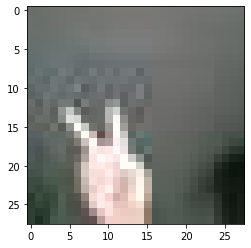

In [14]:
plt.imshow(x_test[0])
print(f"라벨: {y_test[0]}")

테스트 데이터도 학습 데이터와 같이 정규화를 해주자.

단, 테스트 데이터는 나중에 잘못 판단한 데이터를 이미지로 출력을 할 것이기 때문에  
정규화된 이미지는 따른 곳에 저장한다.

In [15]:
x_test_normalized = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

## 7. 얼마나 잘 만들었는지 확인하기

그럼 준비된 테스트 데이터로 학습시킨 모델을 평가해보자.

In [16]:
test_loss, test_accuracy = model.evaluate(x_test_normalized, y_test, verbose=2)
print(f"test_loss : {test_loss}")
print(f"test_accuracy : {test_accuracy}")

10/10 - 2s - loss: 3.4759 - accuracy: 0.6133
test_loss : 3.4759154319763184
test_accuracy : 0.6133333444595337


61%라는 정확도가 나왔다.  
이것도 나름 배경이 너무 튀는 것은 뺀 데이터이다.

그렇다면 어떻게 확률을 개선할지 생각해보자.

## 8. 원인 분석하기

일단 테스트 데이터에서 잘못 판단한 이미지를 출력해보자.

잘못 평가한 이미지 개수 : 116


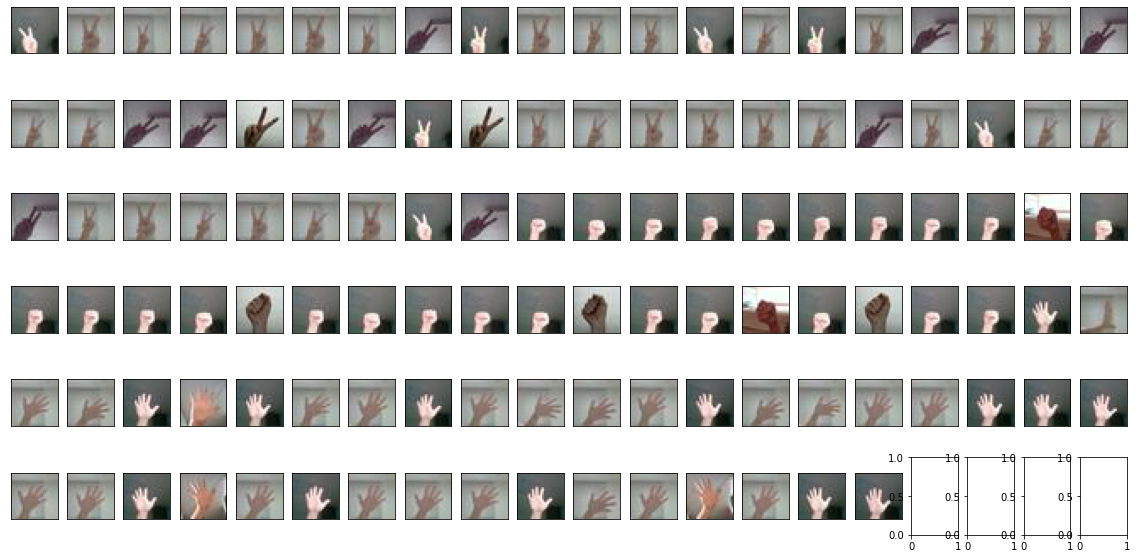

In [17]:
y_predict = model.predict(x_test_normalized) # 테스트 데이터에 따른 예상 결과

correct_prediction = np.equal(np.argmax(y_predict, 1), y_test) # 올바르게 평가한 것들
wrong_indices = np.where(correct_prediction == 0)[0] # 잘못 평가한 이미지 인덱스들

print(f"잘못 평가한 이미지 개수 : {len(wrong_indices)}")

cols = 20
rows = int(len(wrong_indices) / cols) + 1
figure, axes = plt.subplots(nrows=rows, ncols=cols)
figure.set_size_inches(20, 10)  # 그래프 크기를 조정

for i, ax in zip(wrong_indices, np.ravel(axes)):
    ax.imshow(x_test[i])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

### <span style="color:red">문제1 : 단일한 환경(배경)에서 학습을 시켰다.</span>
학습 시킨 이미지가 모두 직접찍은 같은 환경인데, 비해 테스트 데이터는 다른 환경을 가졌다.

그리고 잘못 판단한 이미지에서 주목할 만한 이미지를 몇개 보자.

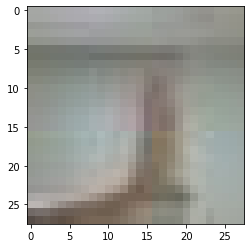

In [18]:
plt.imshow(x_test[wrong_indices[79]])

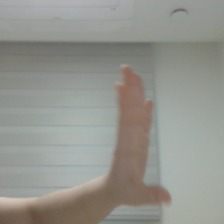

In [19]:
Image.open(os.getenv("HOME") + "/aiffel/rock_scissor_paper/56.jpg")

### <span style="color:red">문제2 : 부정확한 이미지로 학습시켰다.</span>

위의 이미지 처럼 원본사진부터 사람이봐도 알아보기 힘든 모양들이 있다.  
부정확하거나, 학습에 오히려 방해가 될 데이터는 제거해야 한다.

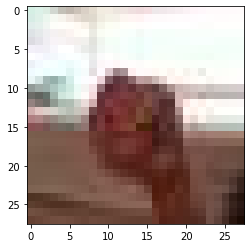

In [20]:
plt.imshow(x_test[wrong_indices[58]])

### <span style="color:red">문제2 : 왼손으로만 학습시켰다.</span>

위 사진처럼 손 모양은 오른손일수도 있다.

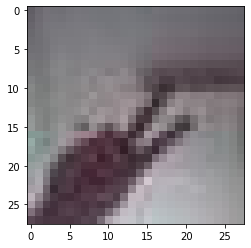

In [21]:
plt.imshow(x_test[wrong_indices[19]])

### <span style="color:red">문제2 : 한쪽 방향으로만 학습시켰다.</span>

학습 데이터는 모두 사진 아래에서 위로 나온 손모양이다.  
위 사진 처럼 대각선이나 옆으로 나온 경우도 있을 것이다.

# 더 좋은 네트워크 만들어보기

## 1. 데이터 만들기

위에서 나온 문제들을 해결하기 위해 새로운 데이터를 준비해야한다.  
테스터 데이터와 다른 여러 환경의 데이터를 준비하자.

* ### 다양성을 늘리기 위해서 여러 환경의 데이터를 합친다.
* ### 부정확하거나 학습에 방해되는 이미지를 제거한다.

## 2. 이미지 Resize 하기

위의 사항을 고려해서 나름 명확한 이미지가 대략 1000개 준비되었다.  
새롭게 준비한 이미지는 다른 폴더에 보관하였다.

준비된 이미지를 똑같이 28x28사이즈로 변경하자.

In [22]:
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/2.0.5/scissor")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/2.0.5/rock")
resize_images(os.getenv("HOME") + "/aiffel/rock_scissor_paper/2.0.5/paper")

258 개의 이미지 크기변경
356 개의 이미지 크기변경
335 개의 이미지 크기변경


## 3. 데이터 불러오기
* ### 좌우 반전을 통해 양손에 대한 이미지를 만든다.
* ### 이미지 회전을 통해 여러 방향에 대한 이미지를 만든다.
* ### 다른 환경에서도 모양으로 구분이 되도록 색을 반전시켜서 이미지를 만든다.

이미지를 로드하는 함수 부분을 많이 변경하였다.

기존 이미지의 좌우반전(2) * 90회전(4) * 색반전(2) = 이미지 * 16의 학습 데이터를 생성한다.

테스트 용 데이터도 이 함수로 만드는데, 굳이 테스트 데이터에 여러 작용을 거칠 필요가 없는 것 같아서  
테스트용의 경우는 is_test=False인자를 True로 줄 경우 기존 이미지 개수 만큼만 만들게 하였다.

default 이미지 데이터의 최대 개수는 16000 이다. (총 이미지는 이미지수 * 16 이다.)  
number_of_data=16000 인자의 개수를 변경하여 최대 개수를 변경가능하다.  
그리고 생성한 이미지 데이터의 개수만큼 반환하도록 return imgs[:idx]로 변경하였다.


In [23]:
def create_four_way_image_data(image, x_data, y_data, idx, label):
    # 이미지를 90도씩 회전하며 4방향으로 생성
    for _ in range(4):
        image = image.transpose(Image.ROTATE_90)
        x_data[idx,:,:,:] = np.array(image, dtype=np.int32)
        y_data[idx] = label
        idx += 1
    return idx


def load_and_transfor_data(img_path, *, number_of_data=16000, is_test = False):  # 테스트일 경우 is_test=True
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    x_data=np.zeros([number_of_data, 28, 28, 3], dtype=np.int32)
    y_data=np.zeros(number_of_data, dtype=np.int32)
    idx=0

    def calc_image_data(label, folder_name):
        for file in glob.iglob(img_path+f'/{folder_name}/*.jpg'):
            nonlocal idx
            image = Image.open(file)
            idx = create_four_way_image_data(image, x_data, y_data, idx, label)
            
            if is_test:     # 테스트 데이터인 경우 다른 변형 처리를 넘긴다.
                continue

            image = image.transpose(Image.FLIP_LEFT_RIGHT)  # 좌우반전
            idx = create_four_way_image_data(image, x_data, y_data, idx, label)

            # 색 반전
            for x in range(1 , 28):
                for y in range(1, 28):
                    image.putpixel((x,y), int(255-image.getpixel((x,y))[0]))

            idx = create_four_way_image_data(image, x_data, y_data, idx, label)

            image = image.transpose(Image.FLIP_LEFT_RIGHT)  # 좌우반전
            idx = create_four_way_image_data(image, x_data, y_data, idx, label)

    calc_image_data(0, 'scissor') # 각 라벨로 데이터 생성
    calc_image_data(1, 'rock')
    calc_image_data(2, 'paper')
      
    print(f"로드된 데이터의 이미지 개수는 {idx} 입니다.")
    return x_data[:idx], y_data[:idx]

준비해둔 학습데이터와 테스터 데이터를 로드하고, 정규화한다.  

In [24]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/2.0.5"
(x_train, y_train) = load_and_transfor_data(image_dir_path)
x_train = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/2.0.5/test"
(x_test, y_test) = load_and_transfor_data(image_dir_path, is_test=True)
x_test_normalized = x_test/255.0

로드된 데이터의 이미지 개수는 15184 입니다.
로드된 데이터의 이미지 개수는 1200 입니다.


## 4. 딥러닝 네트워크 설계하기
* ### 모델 레이어에 batch normalize를 추가한다.
* ### 앙상블 효과를 위해 모델을 여러개 생성한다.
* ### 학습한 모델을 저장해서 다음번 모델에서 앙상블 모델을 추가한다.

앙상블 효과를 주기위해 모델의 생성과 학습을 함수로 만들었다.  
클래스로 만들까도 생각했지만, 딱히 필요성을 못 느껴서 함수 2개로 구성하였다.

아래 함수는 모델을 생성해서 반환하는 함수이다.  
모델의 구성은 각 레이어 사이에 batch normalize를 추가 하였다.

regularization효과가 있기 때문에 따로 dropout등을 하지 않아도 되고,  
Internal Covariate Shift문제를 해결하여 안정적인 학습이 가능하게 도와준다.

In [25]:
def create_model(channels_1, channels_2, channels_3, channels_4, dense_output, *, learning_rate):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels_1, (3,3), activation='relu', input_shape=(28,28,3)))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_2, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_3, (3,3), activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_4, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(dense_output, activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

함수를 통해 임시로 생성된 모델의 구성

In [26]:
dummy_model = create_model(64, 128, 128, 64, 128, learning_rate=0.01)
dummy_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 128)      

## 5. 딥러닝 네트워크 학습시키기

기존의 fit부분을 함수로 만들었다.

추가로 학습한 모델을 저장하여 나중에 앙상블 모델로 사용할 수 있게 만들었다.  
파일이름으로 정확도와 오차를 표시하여 어떤 모델인지 확인할 수 있게하였다.

모델 학습 그래프를 파일과 같은 이름으로 저장하여 어떻게 학습되었는지도 확인할 수 있게하였다.

fit과정에 이전의 validation_split으로 확인하던 것을,  
validation_data로 test데이터를 넣어서 학습 도중의 결과를 나타내었다.  

In [27]:
def save_model(model, path, filename, plt):
    file_path = f'{path}/{filename}'
    uniq = 1
    while os.path.exists(file_path + '.h5'):
        file_path = f'{path}/{filename}({uniq})'
        uniq += 1
        
    model.save(file_path + '.h5')
    plt.savefig(file_path + '.png')  # 나중에 확인가능하게 학습 그래프를 이미지로 같은 이름으로 저장한다.
    print(f"모델을 저장하였습니다. 저장경로 : {file_path}.h5")

In [28]:
def train(model : keras.Model, x_train, y_train, x_test, y_test, epochs, *, save_path=None):
    # fit과정 중의 기록인 history를 결과로 받는다.
    hist = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    print(f"test_loss: {test_loss} ")
    print(f"test_accuracy: {test_accuracy}")
    
    # 기록들을 그래프로 나타낸다.
    fig = plt.figure()
    loss_ax = fig.add_subplot(2, 1, 1)
    acc_ax = fig.add_subplot(2, 1, 2)
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    
    if save_path is not None:
        filename = f'E01_{test_accuracy:f}_{test_loss:f}' # 정확도와 오차를 이름으로 한다
        save_model(model, save_path, filename, plt)   # 학습시킨 모델을 저장한다.
    
    plt.show()

하이퍼 파라미터로 ensembles를 추가하였다.

ensembles의 수만큼 모델을 생성하고 학습시킨다.  
학습시간이 너무 길어지지 않게 적당히 3개의 모델만 만들었다.

만약 이전에 학습시켜놓은 모델 중 괜찮은게 있다면 불러서 같이 사용하도록 하였다.

learing_rate의 경우 여러가지 실험결과 0.001일 경우 부터 테스트 데이터의 정답률이 0.99이상으로 갔다.  
다만 0.001이 경우 테스트 데이터의 변동률이 커서 0.0001로 실험을 진행하자 적은 변동 폭으로  
천천히 오르기는 하는데 150번의 epoch에서도 0.97정도로 학습이 너무 느렸다.  
결과적으로 0.0005에서 100번에서 안정되는 학습률과 속도를 보였다.

3 개의 모델을 불러왔습니다.
Epoch 1/100
475/475 [==============================] - 18s 24ms/step - loss: 0.5025 - accuracy: 0.7949 - val_loss: 0.3448 - val_accuracy: 0.8575
Epoch 2/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0790 - accuracy: 0.9725 - val_loss: 0.3158 - val_accuracy: 0.8858
Epoch 3/100
475/475 [==============================] - 6s 13ms/step - loss: 0.0419 - accuracy: 0.9884 - val_loss: 0.5007 - val_accuracy: 0.8492
Epoch 4/100
475/475 [==============================] - 8s 16ms/step - loss: 0.0318 - accuracy: 0.9898 - val_loss: 1.7269 - val_accuracy: 0.5983
Epoch 5/100
475/475 [==============================] - 8s 16ms/step - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.3695 - val_accuracy: 0.9225
Epoch 6/100
475/475 [==============================] - 8s 16ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.3490 - val_accuracy: 0.9058
Epoch 7/100
475/475 [==============================] - 8s 16ms/step - loss: 0.0154 - accuracy: 0.9944 - val_loss: 0.17

475/475 [==============================] - 6s 12ms/step - loss: 3.7908e-04 - accuracy: 0.9999 - val_loss: 0.0734 - val_accuracy: 0.9742
Epoch 58/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0615 - val_accuracy: 0.9842
Epoch 59/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0014 - accuracy: 0.9993 - val_loss: 0.2381 - val_accuracy: 0.9300
Epoch 60/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1595 - val_accuracy: 0.9550
Epoch 61/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1123 - val_accuracy: 0.9583
Epoch 62/100
475/475 [==============================] - 6s 12ms/step - loss: 5.5056e-04 - accuracy: 0.9999 - val_loss: 0.1627 - val_accuracy: 0.9617
Epoch 63/100
475/475 [==============================] - 6s 12ms/step - loss: 6.7404e-04 - accuracy: 0.9999 - val_loss: 0.0579 - val_acc

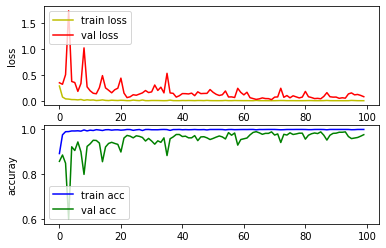

Epoch 1/100
475/475 [==============================] - 7s 12ms/step - loss: 0.5137 - accuracy: 0.7899 - val_loss: 0.2709 - val_accuracy: 0.8908
Epoch 2/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0762 - accuracy: 0.9736 - val_loss: 1.1801 - val_accuracy: 0.6900
Epoch 3/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.3363 - val_accuracy: 0.8708
Epoch 4/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.5393 - val_accuracy: 0.8342
Epoch 5/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0223 - accuracy: 0.9942 - val_loss: 0.1289 - val_accuracy: 0.9525
Epoch 6/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 0.1851 - val_accuracy: 0.9225
Epoch 7/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.2598 - val_accuracy:

475/475 [==============================] - 6s 12ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0841 - val_accuracy: 0.9800
Epoch 58/100
475/475 [==============================] - 6s 12ms/step - loss: 9.7973e-04 - accuracy: 0.9998 - val_loss: 0.0628 - val_accuracy: 0.9792
Epoch 59/100
475/475 [==============================] - 6s 12ms/step - loss: 7.0049e-04 - accuracy: 0.9998 - val_loss: 0.0449 - val_accuracy: 0.9825
Epoch 60/100
475/475 [==============================] - 6s 12ms/step - loss: 1.7356e-04 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9817
Epoch 61/100
475/475 [==============================] - 6s 12ms/step - loss: 2.4194e-04 - accuracy: 1.0000 - val_loss: 0.1770 - val_accuracy: 0.9567
Epoch 62/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0058 - accuracy: 0.9977 - val_loss: 0.3916 - val_accuracy: 0.9108
Epoch 63/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1817 - val

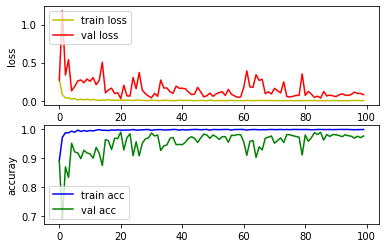

Epoch 1/100
475/475 [==============================] - 7s 12ms/step - loss: 0.4930 - accuracy: 0.8007 - val_loss: 0.2480 - val_accuracy: 0.8842
Epoch 2/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0792 - accuracy: 0.9733 - val_loss: 0.2300 - val_accuracy: 0.9050
Epoch 3/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0445 - accuracy: 0.9854 - val_loss: 1.3474 - val_accuracy: 0.6367
Epoch 4/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 1.0341 - val_accuracy: 0.6883
Epoch 5/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.6506 - val_accuracy: 0.8533
Epoch 6/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 15.5024 - val_accuracy: 0.3333
Epoch 7/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0154 - accuracy: 0.9957 - val_loss: 0.4644 - val_accuracy

475/475 [==============================] - 5s 12ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.1118 - val_accuracy: 0.9700
Epoch 58/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.0884 - val_accuracy: 0.9792
Epoch 59/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1148 - val_accuracy: 0.9617
Epoch 60/100
475/475 [==============================] - 5s 12ms/step - loss: 3.6124e-04 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9758
Epoch 61/100
475/475 [==============================] - 6s 12ms/step - loss: 1.1912e-04 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9767
Epoch 62/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.1204 - val_accuracy: 0.9608
Epoch 63/100
475/475 [==============================] - 6s 12ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0389 - val_accurac

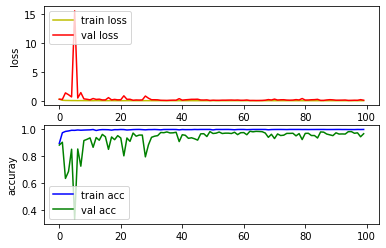

In [29]:
# 하이퍼 파라미터들
train_epochs = 100
channels_1 = 64
channels_2 = 128
channels_3 = 128
channels_4 = 64
dense_output = 128
learning_rate = 0.0005
ensembles = 3

save_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/models"

# 모델을 학습하여 저장하기 전에 저장된 모델들을 불러온다.
loaded_models = [keras.models.load_model(file) for file in glob.iglob(save_path + '/*.h5')]
print(f"{len(loaded_models)} 개의 모델을 불러왔습니다.")

# 앙상블을 할 수만큼 모델들을 생성한다.
models = [create_model(channels_1, channels_2, channels_3, channels_4, dense_output,
                       learning_rate=learning_rate) for _ in range(ensembles)]
                       
for model in models:  # 각 모델들을 학습 시킨다.
    train(model, x_train, y_train, x_test_normalized, y_test, train_epochs, save_path=save_path)

앙상블의 효과를 보기 위해 tensorflow.keras.Model의 predict함수 대신 직접 accuracy를 구하였다.


In [33]:
def predict(models):
    predictions = [model.predict(x_test_normalized) for model in models]
    predictions = np.sum(predictions, axis=0) / len(models)

    ensemble_correct_prediction = np.equal(np.argmax(predictions, 1), y_test)
    print(f"Ensemble accuracy: {np.mean(ensemble_correct_prediction)}\n")
    return predictions, ensemble_correct_prediction
    
print("<만들어낸 모델들로 평가>")
predict(models)

print("<로드된 모델들로 평가>")
predict(loaded_models)

print("<합쳐진 모델들로 평가>")
predictions, ensemble_correct_prediction = predict(models + loaded_models) # 미리 불러왔던 모델들을 합친다.

<만들어낸 모델들로 평가>
Ensemble accuracy: 0.9891666666666666

<로드된 모델들로 평가>
Ensemble accuracy: 0.995

<합쳐진 모델들로 평가>
Ensemble accuracy: 0.9966666666666667



불러온 모델까지 합친 결과는 0.996이 나왔다.
여러번 실험 결과는 0.989~0.998사이를 왔다갔다 하였다.

잘못 평가된 데이터를 모아보았다.

잘못 평가한 이미지 개수 : 4


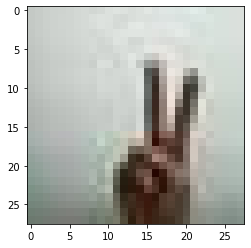

확률평가 (가위:0.340908),(바위:0.000113),(보:0.658979)


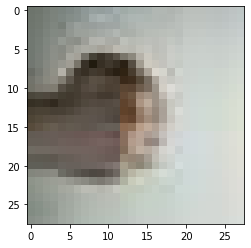

확률평가 (가위:0.553878),(바위:0.445064),(보:0.001057)


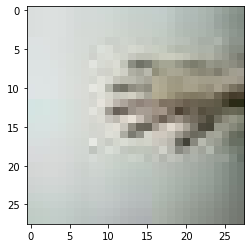

확률평가 (가위:0.524219),(바위:0.000003),(보:0.475778)


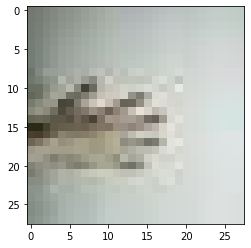

확률평가 (가위:0.533926),(바위:0.000002),(보:0.466072)


In [34]:
wrong_indices = np.where(ensemble_correct_prediction == 0)[0]
print(f"잘못 평가한 이미지 개수 : {len(wrong_indices)}")

for i in wrong_indices:
    plt.imshow(x_test[i])
    plt.show()
    print(f"확률평가 (가위:{predictions[i,0]:f}),(바위:{predictions[i,1]:f}),(보:{predictions[i,2]:f})")

틀린 내용을 자세히 보면 가위와 보의 경우, 0.05퍼 정도의 확률차이로 잘못 판단한 것으로 나온다.

그리고 주먹이 크게 나온 사진의 경우는 보와 바위가 비슷한 확률로 나온다.  
바위의 경우는 손등이 나온 경우 손가락이 안보여서 붙여진 보와 구분이 힘든 것으로 생각된다.

이 부분은 픽셀이 줄어들면서 구분하기 힘들어 진 부분도 있다고 예상된다.

## 총평

가위, 바위, 보 이미지를 인식하는 모델을 만들어보았다.  
초기의 스스로 찍은 300개(100 * 3) 이미지로 학습한 경우 같은 환경(스스로 찍은)에서는  
테스트데이터를 전혀 학습에 영향을 주지 않아도 1.0이 나왔었다.

문제는 다른 환경(다른 사람이 찍은 이미지)에서는 정답률이 매우 떨어졌다.  
당연히 스스로 찍은 하나의 환경에서 학습한 데이터이기 때문이다.

그래서 다른 분들이 올린 이미지를 모아서 학습을 시키고, 또 다른 사람의 이미지로  
테스트를 했지만, 여전히 성능이 좋지않았다.

전체적으로 학습데이터의 부족과 잘못된 학습 데이터가 있다는 문제가 생각되었다.

우선적으로 사람이 보기에도 애매한 이미지(잔상, 보를 옆면으로 일자로 편 경우등)를  
제거하여, 확실히 구분 가능한 학습데이터들만 남겼고, 너무 배경이 화려해서 손에 이미지가  
구분이 안가는 경우도 제외시켰다.

그 다음으로는 너무 단일 방향인 손 이미지들을 좌우반전과 회전을 통해 다양한 이미지를 얻었다.  
거기에 환경마다 색이 다를 수 있고, 실제로 가위/바위/보의 경우 색이 중요하지 않다고 판단하여,  
색을 반전시켜서 학습시켰다.

확실히 위의 이미지의 다양성을 늘리니깐 0.9이상으로 accuracy가 늘었다.  
거기에 많은 epohc에서 테스트 정답률이 떨어지는 overfiting을 막기 위해 batch normalization을 사용하였다.  
추가적으로 마지막 애매하게 안오르는 accuracy를 올리기 위해 ensemble을 사용하여,  
최종적으로 0.996 accuracy를 얻게되었다.

개인적으로 좀더 화질을 올리거나 다양한(대신 확실히 분류가능한) 데이터가 있으면,  
좀 더 범용적인 인식기를 만들 수 있을 것 같다는 생각이 들었다.